In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import torchvision

In [3]:
from heuristics.model.dataset import TorchDataset, get_pd_dataset, load_images
from heuristics.model.settings import IMAGES_DIR
from heuristics.model.classifier import RoomModel
from heuristics.model.trainer import TrainerUtils
from heuristics.model.utils import get_preprocessor

from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
import torch
from tqdm import tqdm_notebook

import numpy as np
import os
from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
import matplotlib.pyplot as plt

from heuristics.model.trainer import predict_img_batch

from PIL import Image

from heuristics.model.metrics import Metrics

from heuristics.model.settings import ROOM_TYPES, VALID_ROOM_TYPES, CLASS_NAME_MAPPING

from heuristics.model.utils import plot_imgs_with_labels, plot_sample, load_images

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

/usr/local/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/usr/local/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/usr/local/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/usr/local/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.8/site-

In [4]:
# set your own paths
BASE_DIR_PATH = '/app/'
BASE_DATA_DIR = '/data/'

CSV_DATA_DIR = os.path.join(BASE_DIR_PATH, '/heuristics/data/')
TRAIN_IMGS_DATA_DIR = os.path.join(BASE_DATA_DIR, 'train_images')
TEST_IMGS_DATA_DIR = os.path.join(BASE_DATA_DIR, 'test_images')

TRAIN_DF_DIR = os.path.join(BASE_DIR_PATH, '/app/heuristics/data/AAA_dataset_course_ha_TOLOKA_dataset_new.csv')
TEST_DF_DIR = os.path.join(BASE_DIR_PATH, '/app/heuristics/data/AAA_dataset_course_ha_TRUE_TEST.csv')

In [5]:
train_df = pd.read_csv(TRAIN_DF_DIR)
test_df = pd.read_csv(TEST_DF_DIR)

In [6]:
%%time
# скачиваем картинки
load_images(train_df['image'], TRAIN_IMGS_DATA_DIR)
load_images(test_df['image'], TEST_IMGS_DATA_DIR)

CPU times: user 8.69 s, sys: 9.99 s, total: 18.7 s
Wall time: 10.4 s


In [7]:
# определим локальный путь до картинок
train_df['img_path'] = train_df['image'].map(
    lambda x: os.path.join(TRAIN_IMGS_DATA_DIR, os.path.split(x)[-1])
)
test_df['img_path'] = test_df['image'].map(
    lambda x: os.path.join(TEST_IMGS_DATA_DIR, os.path.split(x)[-1])
)

<AxesSubplot:ylabel='result'>

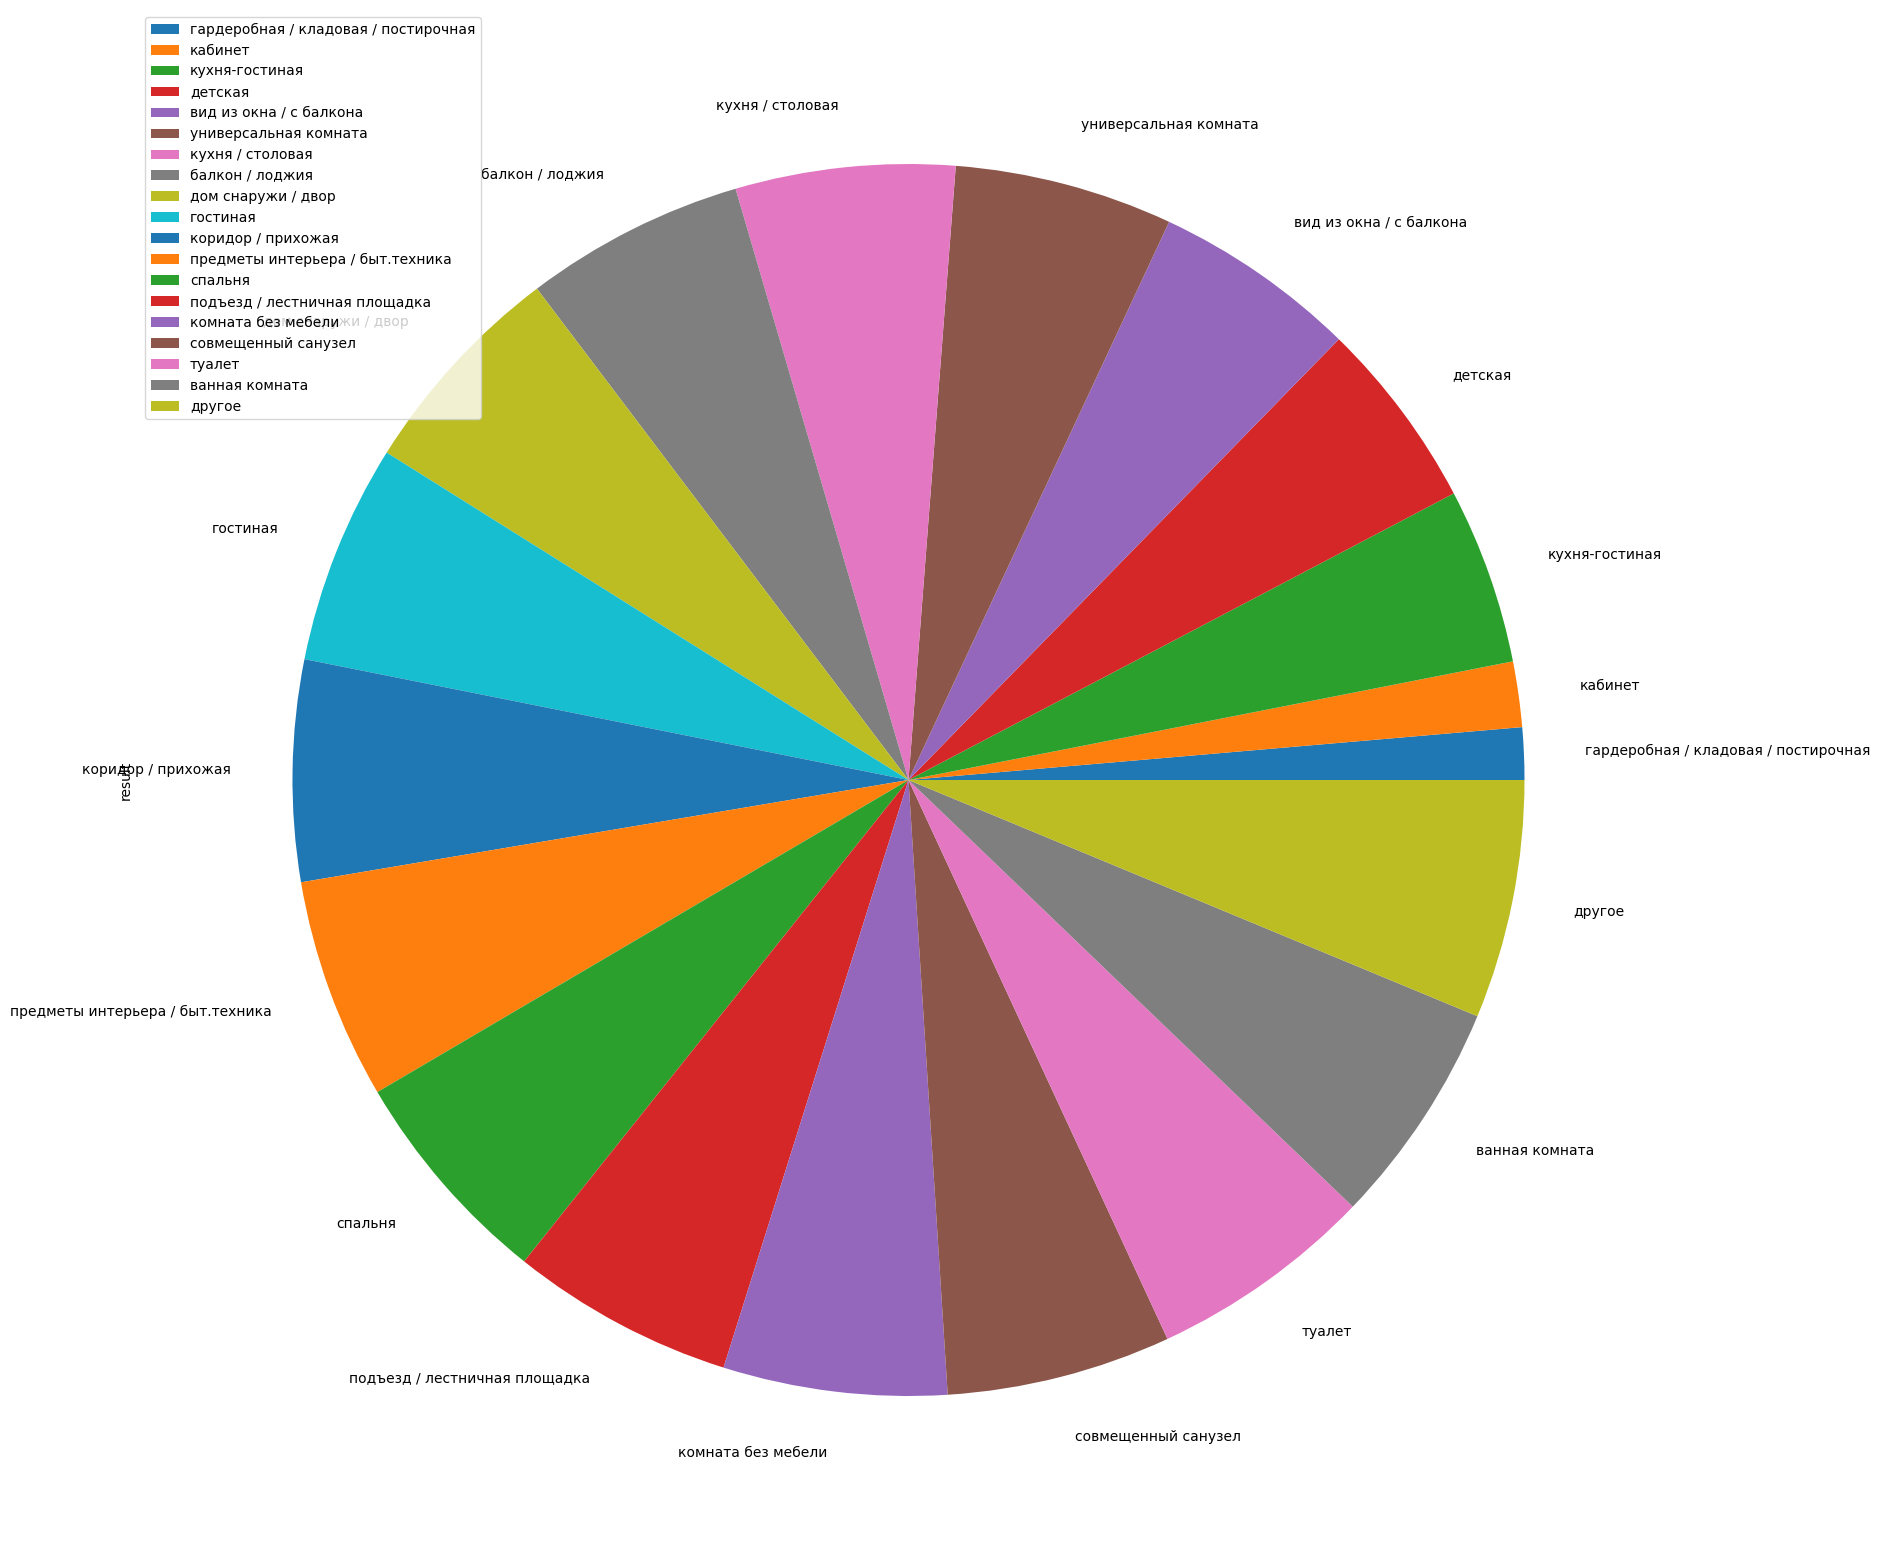

In [8]:
train_df['room_type'] = train_df['result'].map(CLASS_NAME_MAPPING)
train_df.groupby('room_type').count().sort_values('result').plot.pie(y='result', figsize=(20, 20))

In [ ]:
# картинки из одного айтема не могут лежать в разных сетах

In [9]:
test_df[test_df['type'] == 'heuristics']['label'].value_counts()

гардеробная / кладовая / постирочная    202
кабинет                                 189
детская                                  65
другое                                   50
предметы интерьера / быт.техника         44
Name: label, dtype: int64

In [10]:
columns = [TorchDataset.img_path_column, TorchDataset.label_column, TorchDataset.image_id_column, 'label', 'ratio']
#print(columns)

# train_df = pd.read_csv('/app/data/TOLOKA_dataset_HA_1.csv')#[columns]

# test_df = pd.read_csv('/app/data/TEST_dataset_HA.csv')#[columns]

# train_df['img_path'] = train_df['image_id_ext'].map(lambda x: f'/data/images_labeled/{int(x)}.jpg')
# test_df['img_path'] = test_df['image_id_ext'].map(lambda x: f'/data/images_labeled/{int(x)}.jpg')

In [ ]:
# train_df_new = pd.concat([train_df[train_df['label'] != 'детская'], 
#                           train_df[train_df['label'] == 'детская'].sample(100)])

In [ ]:
dataset_train = TorchDataset(image_dir=IMAGES_DIR, df=train_df, transformer=get_preprocessor())
dataset_test = TorchDataset(image_dir=IMAGES_DIR, df=test_df, transformer=get_preprocessor())
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
device = 'cuda:3'
room_clf = RoomModel(num_classes=len(ROOM_TYPES))

optimizer = AdamW(room_clf.parameters(), lr=0.002)
room_clf = room_clf.to(device)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard',
                       experiment_tag='resnet18_baseline_detsk_less')
trainer.training_loop(
    room_clf,
    train_dataloader,
    test_dataloader,
    optimizer,
    epoch_num=15,
    validate_every=10,
    verbose=True,
)

In [ ]:
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')
test_predictions, test_probas, test_targets, _ = trainer.predict(
    room_clf, test_dataloader, with_all_probas=False)

metrics_scorer = Metrics(class_mapping=CLASS_NAME_MAPPING)
scores_df_base = metrics_scorer.get_accuracies_df(test_targets, test_predictions)

In [ ]:
scores_df_base

### Наша базовая модель с обучением

In [ ]:
device = 'cuda:3'
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')

optimizer = AdamW(room_clf.parameters(), lr=0.002)
room_clf = room_clf.to(device)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard', experiment_tag='model_resnet18_baseline_detsk_less')
trainer.training_loop(
    room_clf,
    train_dataloader,
    test_dataloader,
    optimizer,
    epoch_num=15,
    validate_every=10,
    verbose=True,
)

test_predictions, test_probas, test_targets, _ = trainer.predict(room_clf, test_dataloader, with_all_probas=False)

test_df['result_pred'] = test_predictions
test_df['label_pred'] = test_df['result_pred'].map(CLASS_NAME_MAPPING)
test_df['proba'] = test_probas

scores_df_base= metrics_scorer.get_accuracies_df(test_targets, test_predictions)

In [ ]:
scores_df_base

### Базовая модель без обучения

In [ ]:
device = 'cuda:3'
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')

optimizer = AdamW(room_clf.parameters(), lr=0.002)
room_clf = room_clf.to(device)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard', experiment_tag='model_resnet18_baseline_detsk_less')

test_predictions, test_probas, test_targets, _ = trainer.predict(room_clf, test_dataloader, with_all_probas=False)

test_df['result_pred'] = test_predictions
test_df['label_pred'] = test_df['result_pred'].map(CLASS_NAME_MAPPING)
test_df['proba'] = test_probas

scores_df_base= metrics_scorer.get_accuracies_df(test_targets, test_predictions)

In [ ]:
scores_df_base

## Эксперименты

#### Аугментации

In [17]:
import math
from enum import Enum
from typing import Dict, List, Optional, Tuple, Any

import torch
from torch import Tensor
import torchvision.transforms.functional as F
from torchvision.transforms import functional_tensor as F_t
from torchvision.transforms import functional_pil as F_pil
from torchvision.utils import _log_api_usage_once
from torchvision.transforms.functional import InterpolationMode


@torch.jit.unused
def _is_pil_image(img: Any) -> bool:
    return isinstance(img, Image.Image)

@torch.jit.unused
def get_dimensions_p(img: Any) -> List[int]:
    if _is_pil_image(img):
        if hasattr(img, "getbands"):
            channels = len(img.getbands())
        else:
            channels = img.channels
        width, height = img.size
        return [channels, height, width]
    raise TypeError(f"Unexpected type {type(img)}")

def _is_tensor_a_torch_image(x: Tensor) -> bool:
    return x.ndim >= 2


def _assert_image_tensor(img: Tensor) -> None:
    if not _is_tensor_a_torch_image(img):
        raise TypeError("Tensor is not a torch image.")

def get_dimensions_t(img: Tensor) -> List[int]:
    _assert_image_tensor(img)
    channels = 1 if img.ndim == 2 else img.shape[-3]
    height, width = img.shape[-2:]
    return [channels, height, width]

def get_dimensions(img: Tensor) -> List[int]:
    """Returns the dimensions of an image as [channels, height, width].

    Args:
        img (PIL Image or Tensor): The image to be checked.

    Returns:
        List[int]: The image dimensions.
    """
    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(get_dimensions)
    if isinstance(img, torch.Tensor):
        return get_dimensions_t(img)

    return get_dimensions_p(img)

def _apply_op(
    img: Tensor, op_name: str, magnitude: float, interpolation: InterpolationMode, fill: Optional[List[float]]
):
    if op_name == "ShearX":
        # magnitude should be arctan(magnitude)
        # official autoaug: (1, level, 0, 0, 1, 0)
        # https://github.com/tensorflow/models/blob/dd02069717128186b88afa8d857ce57d17957f03/research/autoaugment/augmentation_transforms.py#L290
        # compared to
        # torchvision:      (1, tan(level), 0, 0, 1, 0)
        # https://github.com/pytorch/vision/blob/0c2373d0bba3499e95776e7936e207d8a1676e65/torchvision/transforms/functional.py#L976
        img = F.affine(
            img,
            angle=0.0,
            translate=[0, 0],
            scale=1.0,
            shear=[math.degrees(math.atan(magnitude)), 0.0],
            interpolation=interpolation,
            fill=fill,
            center=[0, 0],
        )
    elif op_name == "ShearY":
        # magnitude should be arctan(magnitude)
        # See above
        img = F.affine(
            img,
            angle=0.0,
            translate=[0, 0],
            scale=1.0,
            shear=[0.0, math.degrees(math.atan(magnitude))],
            interpolation=interpolation,
            fill=fill,
            center=[0, 0],
        )
    elif op_name == "TranslateX":
        img = F.affine(
            img,
            angle=0.0,
            translate=[int(magnitude), 0],
            scale=1.0,
            interpolation=interpolation,
            shear=[0.0, 0.0],
            fill=fill,
        )
    elif op_name == "TranslateY":
        img = F.affine(
            img,
            angle=0.0,
            translate=[0, int(magnitude)],
            scale=1.0,
            interpolation=interpolation,
            shear=[0.0, 0.0],
            fill=fill,
        )
    elif op_name == "Rotate":
        img = F.rotate(img, magnitude, interpolation=interpolation, fill=fill)
    elif op_name == "Brightness":
        img = F.adjust_brightness(img, 1.0 + magnitude)
    elif op_name == "Color":
        img = F.adjust_saturation(img, 1.0 + magnitude)
    elif op_name == "Contrast":
        img = F.adjust_contrast(img, 1.0 + magnitude)
    elif op_name == "Sharpness":
        img = F.adjust_sharpness(img, 1.0 + magnitude)
    elif op_name == "Posterize":
        img = F.posterize(img, int(magnitude))
    elif op_name == "Solarize":
        img = F.solarize(img, magnitude)
    elif op_name == "AutoContrast":
        img = F.autocontrast(img)
    elif op_name == "Equalize":
        img = F.equalize(img)
    elif op_name == "Invert":
        img = F.invert(img)
    elif op_name == "Identity":
        pass
    else:
        raise ValueError(f"The provided operator {op_name} is not recognized.")
    return img

class AugMix(torch.nn.Module):
    r"""AugMix data augmentation method based on
    `"AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty" <https://arxiv.org/abs/1912.02781>`_.
    If the image is torch Tensor, it should be of type torch.uint8, and it is expected
    to have [..., 1 or 3, H, W] shape, where ... means an arbitrary number of leading dimensions.
    If img is PIL Image, it is expected to be in mode "L" or "RGB".

    Args:
        severity (int): The severity of base augmentation operators. Default is ``3``.
        mixture_width (int): The number of augmentation chains. Default is ``3``.
        chain_depth (int): The depth of augmentation chains. A negative value denotes stochastic depth sampled from the interval [1, 3].
            Default is ``-1``.
        alpha (float): The hyperparameter for the probability distributions. Default is ``1.0``.
        all_ops (bool): Use all operations (including brightness, contrast, color and sharpness). Default is ``True``.
        interpolation (InterpolationMode): Desired interpolation enum defined by
            :class:`torchvision.transforms.InterpolationMode`. Default is ``InterpolationMode.NEAREST``.
            If input is Tensor, only ``InterpolationMode.NEAREST``, ``InterpolationMode.BILINEAR`` are supported.
        fill (sequence or number, optional): Pixel fill value for the area outside the transformed
            image. If given a number, the value is used for all bands respectively.
    """

    def __init__(
        self,
        severity: int = 3,
        mixture_width: int = 3,
        chain_depth: int = -1,
        alpha: float = 1.0,
        all_ops: bool = True,
        interpolation: InterpolationMode = InterpolationMode.BILINEAR,
        fill: Optional[List[float]] = None,
    ) -> None:
        super().__init__()
        self._PARAMETER_MAX = 10
        if not (1 <= severity <= self._PARAMETER_MAX):
            raise ValueError(f"The severity must be between [1, {self._PARAMETER_MAX}]. Got {severity} instead.")
        self.severity = severity
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth
        self.alpha = alpha
        self.all_ops = all_ops
        self.interpolation = interpolation
        self.fill = fill

    def _augmentation_space(self, num_bins: int, image_size: Tuple[int, int]) -> Dict[str, Tuple[Tensor, bool]]:
        s = {
            # op_name: (magnitudes, signed)
            "ShearX": (torch.linspace(0.0, 0.3, num_bins), True),
            "ShearY": (torch.linspace(0.0, 0.3, num_bins), True),
            "TranslateX": (torch.linspace(0.0, image_size[1] / 3.0, num_bins), True),
            "TranslateY": (torch.linspace(0.0, image_size[0] / 3.0, num_bins), True),
            "Rotate": (torch.linspace(0.0, 30.0, num_bins), True),
            "Posterize": (4 - (torch.arange(num_bins) / ((num_bins - 1) / 4)).round().int(), False),
            "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),
            "AutoContrast": (torch.tensor(0.0), False),
            "Equalize": (torch.tensor(0.0), False),
        }
        if self.all_ops:
            s.update(
                {
                    "Brightness": (torch.linspace(0.0, 0.9, num_bins), True),
                    "Color": (torch.linspace(0.0, 0.9, num_bins), True),
                    "Contrast": (torch.linspace(0.0, 0.9, num_bins), True),
                    "Sharpness": (torch.linspace(0.0, 0.9, num_bins), True),
                }
            )
        return s

    @torch.jit.unused
    def _pil_to_tensor(self, img) -> Tensor:
        return F.pil_to_tensor(img)

    @torch.jit.unused
    def _tensor_to_pil(self, img: Tensor):
        return F.to_pil_image(img)

    def _sample_dirichlet(self, params: Tensor) -> Tensor:
        # Must be on a separate method so that we can overwrite it in tests.
        return torch._sample_dirichlet(params)

    def forward(self, orig_img: Tensor) -> Tensor:
        """
            img (PIL Image or Tensor): Image to be transformed.

        Returns:
            PIL Image or Tensor: Transformed image.
        """
        fill = self.fill
        channels, height, width = get_dimensions(orig_img)
        if isinstance(orig_img, Tensor):
            img = orig_img
            if isinstance(fill, (int, float)):
                fill = [float(fill)] * channels
            elif fill is not None:
                fill = [float(f) for f in fill]
        else:
            img = self._pil_to_tensor(orig_img)

        op_meta = self._augmentation_space(self._PARAMETER_MAX, (height, width))

        orig_dims = list(img.shape)
        batch = img.view([1] * max(4 - img.ndim, 0) + orig_dims)
        batch_dims = [batch.size(0)] + [1] * (batch.ndim - 1)

        # Sample the beta weights for combining the original and augmented image. To get Beta, we use a Dirichlet
        # with 2 parameters. The 1st column stores the weights of the original and the 2nd the ones of augmented image.
        m = self._sample_dirichlet(
            torch.tensor([self.alpha, self.alpha], device=batch.device).expand(batch_dims[0], -1)
        )

        # Sample the mixing weights and combine them with the ones sampled from Beta for the augmented images.
        combined_weights = self._sample_dirichlet(
            torch.tensor([self.alpha] * self.mixture_width, device=batch.device).expand(batch_dims[0], -1)
        ) * m[:, 1].view([batch_dims[0], -1])

        mix = m[:, 0].view(batch_dims) * batch
        for i in range(self.mixture_width):
            aug = batch
            depth = self.chain_depth if self.chain_depth > 0 else int(torch.randint(low=1, high=4, size=(1,)).item())
            for _ in range(depth):
                op_index = int(torch.randint(len(op_meta), (1,)).item())
                op_name = list(op_meta.keys())[op_index]
                magnitudes, signed = op_meta[op_name]
                magnitude = (
                    float(magnitudes[torch.randint(self.severity, (1,), dtype=torch.long)].item())
                    if magnitudes.ndim > 0
                    else 0.0
                )
                if signed and torch.randint(2, (1,)):
                    magnitude *= -1.0
                aug = _apply_op(aug, op_name, magnitude, interpolation=self.interpolation, fill=fill)
            mix.add_(combined_weights[:, i].view(batch_dims) * aug)
        mix = mix.view(orig_dims).to(dtype=img.dtype)

        if not isinstance(orig_img, Tensor):
            return self._tensor_to_pil(mix)
        return mix


    def __repr__(self) -> str:
        s = (
            f"{self.__class__.__name__}("
            f"severity={self.severity}"
            f", mixture_width={self.mixture_width}"
            f", chain_depth={self.chain_depth}"
            f", alpha={self.alpha}"
            f", all_ops={self.all_ops}"
            f", interpolation={self.interpolation}"
            f", fill={self.fill}"
            f")"
        )
        return s

In [11]:
from torchvision import transforms
from heuristics.model.utils import PadCustom, MAX_IMG_SIZE


device = 'cuda:3'
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')

optimizer = AdamW(room_clf.parameters(), lr=0.00002)  # 0.490988
room_clf = room_clf.to(device)

custom_transformer = transforms.Compose(
        [
            # transforms.RandomRotation((0, 10)),  # 0.498493
            # transforms.RandomPerspective(distortion_scale=0.1, p=0.1),  # 0.492617
            # transforms.Grayscale(num_output_channels=3),  # 0.454670
            # transforms.ColorJitter(brightness=0.1, hue=0.1, contrast=0.1),  # 0.274195
            # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),  # 0.473332
            # AugMix(),  # 0.501024
            transforms.RandAugment(), # 0.502393
            # transforms.TrivialAugmentWide(), # 0.485550
            PadCustom(MAX_IMG_SIZE),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

dataset_train = TorchDataset(image_dir=IMAGES_DIR, df=train_df, custom_transform=custom_transformer)
dataset_test = TorchDataset(image_dir=IMAGES_DIR, df=test_df, transformer=get_preprocessor())
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard', experiment_tag='model_resnet18_baseline_detsk_less_augm_many_epochs_rand')
trainer.training_loop(
    room_clf,
    train_dataloader,
    test_dataloader,
    optimizer,
    epoch_num=100,
    validate_every=10,
    verbose=True,
)

test_predictions, test_probas, test_targets, _ = trainer.predict(room_clf, test_dataloader, with_all_probas=False)

test_df['result_pred'] = test_predictions
test_df['label_pred'] = test_df['result_pred'].map(CLASS_NAME_MAPPING)
test_df['proba'] = test_probas


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 0: 0.4662


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 1: 0.4754


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 2: 0.4823


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 3: 0.4849


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 4: 0.4857


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 5: 0.4887


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 6: 0.4869


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 7: 0.4895


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 8: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 9: 0.4983


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 10: 0.4985


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 11: 0.5017


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 12: 0.4989


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 13: 0.5011


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 14: 0.5007


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 15: 0.5017


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 16: 0.5051


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 17: 0.5027


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 18: 0.5073


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 19: 0.5083


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 20: 0.5073


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 21: 0.5077


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 22: 0.5089


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 23: 0.5061


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 24: 0.5089


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 25: 0.5091


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 26: 0.5091


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 27: 0.5079


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 28: 0.5119


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 29: 0.5105


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 30: 0.5109


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 31: 0.5131


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 32: 0.5091


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 33: 0.5121


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 34: 0.5127


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 35: 0.5113


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 36: 0.5095


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 37: 0.5121


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 38: 0.5143


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 39: 0.5105


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 40: 0.5111


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 41: 0.5127


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 42: 0.5141


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 43: 0.5133


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 44: 0.5111


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 45: 0.5155


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 46: 0.5143


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 47: 0.5129


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 48: 0.5145


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 49: 0.5141


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 50: 0.5137


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 51: 0.5107


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 52: 0.5153


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 53: 0.5145


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 54: 0.5161


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 55: 0.5159


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 56: 0.5127


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 57: 0.5165


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 58: 0.5145


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 59: 0.5143


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 60: 0.5157


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 61: 0.5145


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 62: 0.5127


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 63: 0.5117


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 64: 0.5143


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 65: 0.5143


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 66: 0.5157


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 67: 0.5153


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 68: 0.5167


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 69: 0.5165


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 70: 0.5169


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 71: 0.5139


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 72: 0.5159


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 73: 0.5167


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 74: 0.5175


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 75: 0.5145


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 76: 0.5167


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 77: 0.5147


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 78: 0.5161


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 79: 0.5181


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 80: 0.5163


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 81: 0.5189


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 82: 0.5167


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 83: 0.5173


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 84: 0.5185


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 85: 0.5163


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 86: 0.5181


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 87: 0.5161


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 88: 0.5139


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 89: 0.5169


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 90: 0.5195


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 91: 0.5179


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 92: 0.5133


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 93: 0.5153


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 94: 0.5179


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 95: 0.5189


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 96: 0.5199


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 97: 0.5191


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 98: 0.5157


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 99: 0.5183


  0%|          | 0/156 [00:00<?, ?it/s]

In [12]:
metrics_scorer = Metrics(class_mapping=CLASS_NAME_MAPPING)
scores_df_augm= metrics_scorer.get_accuracies_df(test_targets, test_predictions)
scores_df_augm

,index,precision,recall,f1-score,support
21,weighted avg,0.533934,0.535443,0.513661,4740.0
20,macro avg,0.533448,0.537032,0.515519,4740.0
19,micro avg,0.530962,0.535443,0.533193,4740.0
17,предметы интерьера / быт.техника,0.379592,0.334532,0.355641,278.0
5,кабинет,0.327273,0.064982,0.108434,277.0
11,гардеробная / кладовая / постирочная,0.435897,0.063910,0.111475,266.0
16,другое,0.316265,0.798479,0.453074,263.0
15,подъезд / лестничная площадка,0.686099,0.600000,0.640167,255.0
10,коридор / прихожая,0.548077,0.673228,0.604240,254.0
6,детская,0.389744,0.301587,0.340045,252.0


In [13]:
from torchvision import transforms
from heuristics.model.utils import PadCustom, MAX_IMG_SIZE


device = 'cuda:3'
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')

optimizer = AdamW(room_clf.parameters(), lr=0.00002)  # 0.490988
room_clf = room_clf.to(device)

custom_transformer = transforms.Compose(
        [
            # transforms.RandomRotation((0, 10)),  # 0.498493
            # transforms.RandomPerspective(distortion_scale=0.1, p=0.1),  # 0.492617
            # transforms.Grayscale(num_output_channels=3),  # 0.454670
            # transforms.ColorJitter(brightness=0.1, hue=0.1, contrast=0.1),  # 0.274195
            # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),  # 0.473332
            transforms.RandAugment(num_magnitude_bins=50, magnitude=9, num_ops=4), # 0.517784
            # transforms.TrivialAugmentWide(), # 0.485550
            PadCustom(MAX_IMG_SIZE),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

dataset_train = TorchDataset(image_dir=IMAGES_DIR, df=train_df, custom_transform=custom_transformer)
dataset_test = TorchDataset(image_dir=IMAGES_DIR, df=test_df, transformer=get_preprocessor())
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard', experiment_tag='esnet18_baseline_detsk_less_augm_many_epochs_rand_more_augm')
trainer.training_loop(
    room_clf,
    train_dataloader,
    test_dataloader,
    optimizer,
    epoch_num=100,
    validate_every=10,
    verbose=True,
)

test_predictions, test_probas, test_targets, _ = trainer.predict(room_clf, test_dataloader, with_all_probas=False)

test_df['result_pred'] = test_predictions
test_df['label_pred'] = test_df['result_pred'].map(CLASS_NAME_MAPPING)
test_df['proba'] = test_probas


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 0: 0.463


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 1: 0.4732


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 2: 0.4762


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 3: 0.4766


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 4: 0.4851


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 5: 0.4897


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 6: 0.4913


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 7: 0.4859


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 8: 0.4949


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 9: 0.4921


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 10: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 11: 0.4971


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 12: 0.4981


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 13: 0.4987


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 14: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 15: 0.5029


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 16: 0.5047


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 17: 0.5033


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 18: 0.5031


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 19: 0.5045


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 20: 0.5071


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 21: 0.5087


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 22: 0.5073


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 23: 0.5145


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 24: 0.5105


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 25: 0.5107


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 26: 0.5131


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 27: 0.5161


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 28: 0.5161


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 29: 0.5149


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 30: 0.5159


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 31: 0.5149


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 32: 0.5121


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 33: 0.5189


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 34: 0.5201


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 35: 0.5199


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 36: 0.5193


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 37: 0.5173


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 38: 0.5189


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 39: 0.5169


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 40: 0.5177


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 41: 0.5193


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 42: 0.5161


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 43: 0.5181


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 44: 0.5155


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 45: 0.5153


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 46: 0.5149


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 47: 0.5185


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 48: 0.5169


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 49: 0.5187


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 50: 0.5193


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 51: 0.5195


  0%|          | 0/143 [00:00<?, ?it/s]

Exception in thread Thread-9557:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.8/site-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
  File "/usr/local/lib/python3.8/site-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/usr/local/lib/python3.8/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/usr/local/lib/python3.8/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/usr/local/lib/python3.8/_weakrefset.py", line 119, in update
    for element in other:
  File "/usr/local/lib/python3.8/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 52: 0.5187


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 53: 0.5213


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 54: 0.5181


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 55: 0.5213


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 56: 0.5215


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 57: 0.5211


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 58: 0.5191


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 59: 0.5197


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 60: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 61: 0.5215


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 62: 0.5234


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 63: 0.5225


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 64: 0.5215


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 65: 0.5201


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 66: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 67: 0.5217


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 68: 0.5195


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 69: 0.5221


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 70: 0.5219


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 71: 0.5191


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 72: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 73: 0.5209


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 74: 0.5223


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 75: 0.5266


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 76: 0.524


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 77: 0.5234


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 78: 0.5199


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 79: 0.5225


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 80: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 81: 0.5219


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 82: 0.5201


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 83: 0.5242


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 84: 0.5215


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 85: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 86: 0.5234


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 87: 0.5221


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 88: 0.523


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 89: 0.5248


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 90: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 91: 0.5228


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 92: 0.5238


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 93: 0.526


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 94: 0.5232


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 95: 0.5211


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 96: 0.5167


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 97: 0.5238


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 98: 0.5236


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 99: 0.5189


  0%|          | 0/156 [00:00<?, ?it/s]

In [14]:
scores_df_more_augm= metrics_scorer.get_accuracies_df(test_targets, test_predictions)
scores_df_more_augm

,index,precision,recall,f1-score,support
21,weighted avg,0.541446,0.534388,0.515687,4740.0
20,macro avg,0.541222,0.535931,0.517784,4740.0
19,micro avg,0.534727,0.534388,0.534557,4740.0
17,предметы интерьера / быт.техника,0.402597,0.334532,0.365422,278.0
5,кабинет,0.377358,0.072202,0.121212,277.0
11,гардеробная / кладовая / постирочная,0.488889,0.082707,0.141479,266.0
16,другое,0.315634,0.813688,0.454835,263.0
15,подъезд / лестничная площадка,0.657025,0.623529,0.639839,255.0
10,коридор / прихожая,0.576923,0.649606,0.611111,254.0
6,детская,0.404762,0.269841,0.323810,252.0


In [15]:
from torchvision import transforms
from heuristics.model.utils import PadCustom, MAX_IMG_SIZE


device = 'cuda:3'
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')

optimizer = AdamW(room_clf.parameters(), lr=0.00002)  # 0.490988
room_clf = room_clf.to(device)

custom_transformer = transforms.Compose(
        [
            # transforms.RandomRotation((0, 10)),  # 0.498493
            # transforms.RandomPerspective(distortion_scale=0.1, p=0.1),  # 0.492617
            # transforms.Grayscale(num_output_channels=3),  # 0.454670
            # transforms.ColorJitter(brightness=0.1, hue=0.1, contrast=0.1),  # 0.274195
            # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),  # 0.473332
            transforms.RandAugment(num_magnitude_bins=50, magnitude=17, num_ops=4), # 0.517
            # transforms.TrivialAugmentWide(), # 0.485550
            PadCustom(MAX_IMG_SIZE),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

dataset_train = TorchDataset(image_dir=IMAGES_DIR, df=train_df, custom_transform=custom_transformer)
dataset_test = TorchDataset(image_dir=IMAGES_DIR, df=test_df, transformer=get_preprocessor())
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard', experiment_tag='esnet18_baseline_detsk_less_augm_many_epochs_rand_more_augm')
trainer.training_loop(
    room_clf,
    train_dataloader,
    test_dataloader,
    optimizer,
    epoch_num=100,
    validate_every=10,
    verbose=True,
)

test_predictions, test_probas, test_targets, _ = trainer.predict(room_clf, test_dataloader, with_all_probas=False)

test_df['result_pred'] = test_predictions
test_df['label_pred'] = test_df['result_pred'].map(CLASS_NAME_MAPPING)
test_df['proba'] = test_probas


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 0: 0.4654


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 1: 0.4662


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 2: 0.4708


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 3: 0.4781


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 4: 0.4799


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 5: 0.4777


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 6: 0.4805


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 7: 0.4837


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 8: 0.4883


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 9: 0.4905


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 10: 0.4915


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 11: 0.4911


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 12: 0.4937


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 13: 0.4931


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 14: 0.4953


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 15: 0.4959


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 16: 0.4971


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 17: 0.4983


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 18: 0.4987


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 19: 0.5007


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 20: 0.5041


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 21: 0.5033


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 22: 0.5091


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 23: 0.5091


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 24: 0.5091


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 25: 0.5083


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 26: 0.5103


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 27: 0.5131


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 28: 0.5113


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 29: 0.5117


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 30: 0.5127


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 31: 0.5137


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 32: 0.5135


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 33: 0.5111


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 34: 0.5131


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 35: 0.5135


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 36: 0.5137


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 37: 0.5151


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 38: 0.5173


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 39: 0.5169


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 40: 0.5181


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 41: 0.5133


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 42: 0.5175


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 43: 0.5153


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 44: 0.5189


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 45: 0.5232


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 46: 0.5195


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 47: 0.5171


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 48: 0.5193


  0%|          | 0/143 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
scores_df_stronger_augm= metrics_scorer.get_accuracies_df(test_targets, test_predictions)
scores_df_stronger_augm

,index,precision,recall,f1-score,support
21,weighted avg,0.541446,0.534388,0.515687,4740.0
20,macro avg,0.541222,0.535931,0.517784,4740.0
19,micro avg,0.534727,0.534388,0.534557,4740.0
17,предметы интерьера / быт.техника,0.402597,0.334532,0.365422,278.0
5,кабинет,0.377358,0.072202,0.121212,277.0
11,гардеробная / кладовая / постирочная,0.488889,0.082707,0.141479,266.0
16,другое,0.315634,0.813688,0.454835,263.0
15,подъезд / лестничная площадка,0.657025,0.623529,0.639839,255.0
10,коридор / прихожая,0.576923,0.649606,0.611111,254.0
6,детская,0.404762,0.269841,0.323810,252.0


In [19]:
from torchvision import transforms
from heuristics.model.utils import PadCustom, MAX_IMG_SIZE


device = 'cuda:3'
room_clf, meta_info = RoomModel.from_pretrained('/app/data/models/model_resnet18_baseline_detsk_less')

optimizer = AdamW(room_clf.parameters(), lr=0.00002)  # 0.490988
room_clf = room_clf.to(device)

custom_transformer = transforms.Compose(
        [
            # transforms.RandomRotation((0, 10)),  # 0.498493
            # transforms.RandomPerspective(distortion_scale=0.1, p=0.1),  # 0.492617
            # transforms.Grayscale(num_output_channels=3),  # 0.454670
            # transforms.ColorJitter(brightness=0.1, hue=0.1, contrast=0.1),  # 0.274195
            # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),  # 0.473332
            # transforms.RandAugment(num_magnitude_bins=50, magnitude=17, num_ops=4), # 0.517
            # transforms.TrivialAugmentWide(), # 0.485550
            AugMix(mixture_width=2), # 0.498668
            PadCustom(MAX_IMG_SIZE),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

dataset_train = TorchDataset(image_dir=IMAGES_DIR, df=train_df, custom_transform=custom_transformer)
dataset_test = TorchDataset(image_dir=IMAGES_DIR, df=test_df, transformer=get_preprocessor())
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

trainer = TrainerUtils(device=device, tensorboard_dir='/data/tensorboard', experiment_tag='esnet18_baseline_detsk_less_augm_many_epochs_rand_augmix')
trainer.training_loop(
    room_clf,
    train_dataloader,
    test_dataloader,
    optimizer,
    epoch_num=50,
    validate_every=10,
    verbose=True,
)

test_predictions, test_probas, test_targets, _ = trainer.predict(room_clf, test_dataloader, with_all_probas=False)

test_df['result_pred'] = test_predictions
test_df['label_pred'] = test_df['result_pred'].map(CLASS_NAME_MAPPING)
test_df['proba'] = test_probas


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 0: 0.465


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 1: 0.4775


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 2: 0.4821


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 3: 0.4845


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 4: 0.4917


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 5: 0.4929


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 6: 0.4953


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 7: 0.4937


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 8: 0.4939


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 9: 0.4903


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 10: 0.4929


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 11: 0.4953


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 12: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 13: 0.4965


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 14: 0.4965


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 15: 0.4963


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 16: 0.4979


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 17: 0.4961


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 18: 0.4975


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 19: 0.4989


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 20: 0.4961


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 21: 0.4979


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 22: 0.4963


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 23: 0.4993


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 24: 0.5001


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 25: 0.4951


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 26: 0.4979


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 27: 0.4937


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 28: 0.5023


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 29: 0.4951


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 30: 0.4959


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 31: 0.4947


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 32: 0.4977


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 33: 0.4967


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 34: 0.4983


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 35: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 36: 0.4959


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 37: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 38: 0.4961


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 39: 0.4963


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 40: 0.4949


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 41: 0.4953


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 42: 0.4935


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 43: 0.4969


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 44: 0.4917


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 45: 0.4961


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 46: 0.4967


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 47: 0.4939


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 48: 0.4967


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

INFO:root:val accuracy after epoch 49: 0.4965


  0%|          | 0/156 [00:00<?, ?it/s]

In [20]:
scores_df_augmix= metrics_scorer.get_accuracies_df(test_targets, test_predictions)
scores_df_augmix

,index,precision,recall,f1-score,support
21,weighted avg,0.511785,0.510759,0.496094,4740.0
20,macro avg,0.512339,0.513467,0.498668,4740.0
19,micro avg,0.511083,0.510759,0.510921,4740.0
17,предметы интерьера / быт.техника,0.373444,0.323741,0.346821,278.0
5,кабинет,0.315789,0.064982,0.107784,277.0
11,гардеробная / кладовая / постирочная,0.290698,0.093985,0.142045,266.0
16,другое,0.299566,0.787072,0.433962,263.0
15,подъезд / лестничная площадка,0.586081,0.627451,0.606061,255.0
10,коридор / прихожая,0.535948,0.645669,0.585714,254.0
6,детская,0.337017,0.242063,0.281755,252.0
